# Training a binary autoencoder
This tutorial explains how to train a binary autoencoder in order to obtain a satisfying encoding of your data, to be used as input to the OPU. The architecture and training procedure is adapted from https://arxiv.org/abs/1803.09065.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# fake data
n_samples = 1000
n_features = 100
X = torch.FloatTensor(n_samples, n_features).normal_()
y = torch.FloatTensor(n_samples, n_features).normal_()

In the next cell, we define the autoencoder. The encoder consists of a linear layer, followed by a step function, yielding the binary representation of the data. The decoder is simply the transpose of the encoder. This allows us to learn only the decoder via backprop, which will change the encoder at the same time. The non-differentiable activation is therefore not a problem.

In [3]:
from lightonml.encoding.models import EncoderDecoder
from lightonml.encoding.models import train

In [4]:
batch_size = 64
loader = DataLoader(TensorDataset(X, y), batch_size=batch_size)

In [5]:
bits_per_feature = 10
encoder = EncoderDecoder(n_features, n_features * bits_per_feature)
optimizer = optim.Adam(encoder.parameters(), lr=1e-3)

A newly created encoder is in `training` mode and will return the reconstructed input:

In [6]:
encoder.training

True

We now train it on our data, it is quite fast. The `train` function from `lightonml.encoding.models` will automatically move the encoder to GPU if one is available.

In [7]:
model = train(encoder, loader, optimizer, criterion=F.mse_loss, epochs=10)

Epoch: [1/10], Training Loss: 2.3014791309833527
Epoch: [2/10], Training Loss: 0.8861304149031639
Epoch: [3/10], Training Loss: 0.3710668683052063
Epoch: [4/10], Training Loss: 0.2224256880581379
Epoch: [5/10], Training Loss: 0.1813957393169403
Epoch: [6/10], Training Loss: 0.1691401358693838
Epoch: [7/10], Training Loss: 0.16524941101670265
Epoch: [8/10], Training Loss: 0.16412055306136608
Epoch: [9/10], Training Loss: 0.16388304345309734
Epoch: [10/10], Training Loss: 0.16382171772420406


We set the encoder to `eval` mode:

In [8]:
model.eval()
model.training

False

It is ready to encode:

In [9]:
# we move the data to the GPU where the encoder lives 
# and fetch the binary code from it
Xenc = encoder(X.to('cuda')).cpu()
Xenc.shape, Xenc.dtype, torch.unique(Xenc)

(torch.Size([1000, 1000]), torch.uint8, tensor([0, 1], dtype=torch.uint8))

Of course, `encoder` can also be used on validation and test data, that weren't used to train the autoencoder.

## Using a "real" toy dataset

In [10]:
n_samples = 10000
n_features = 50
X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=5)

We visualise a PCA of the data:

In [11]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

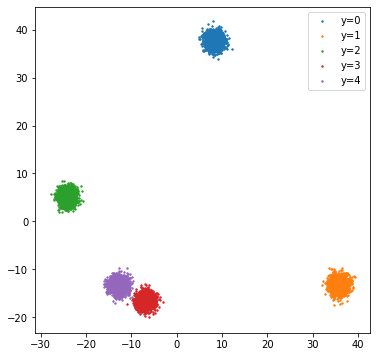

In [12]:
fig, ax = plt.subplots(figsize=(6,6))
for i in np.unique(y):
    ax.scatter(X_pca[y==i,0], X_pca[y==i,1], s=2, label='y={}'.format(i))
    
ax.legend()

We see the 5 clusters created by `make_blobs`. Ideally, our encoder should preserve this structure in the binary encoding. Let us encode the data:

In [13]:
X = torch.from_numpy(X).float()  # by default X in numpy is double, so we cast to float
loader = DataLoader(TensorDataset(X, X), batch_size=batch_size)  # loader in `train` assumes a tuple

In [14]:
encoder = EncoderDecoder(n_features, n_features * bits_per_feature)
optimizer = optim.Adam(encoder.parameters(), lr=1e-3)

In [15]:
encoder.training

True

In [16]:
model = train(encoder, loader, optimizer, criterion=F.mse_loss, epochs=10)

Epoch: [1/10], Training Loss: 13.238989744976069
Epoch: [2/10], Training Loss: 11.991056302550492
Epoch: [3/10], Training Loss: 11.954815147788661
Epoch: [4/10], Training Loss: 11.934128815960733
Epoch: [5/10], Training Loss: 11.907846177459522
Epoch: [6/10], Training Loss: 11.904737241708549
Epoch: [7/10], Training Loss: 11.902793859979909
Epoch: [8/10], Training Loss: 11.902872765899463
Epoch: [9/10], Training Loss: 11.903905589109772
Epoch: [10/10], Training Loss: 11.904929732061495


In [17]:
encoder.eval()
# we move the encoder to cpu, but we could also move the data to GPU
# for faster processing as we did before
encoder.to('cpu')
Xenc = encoder(X)
Xenc.shape, Xenc.dtype, torch.unique(Xenc)

(torch.Size([10000, 500]), torch.uint8, tensor([0, 1], dtype=torch.uint8))

And we visualize it again:

In [18]:
pca = PCA(n_components=2)
Xenc_pca = pca.fit_transform(Xenc.numpy())

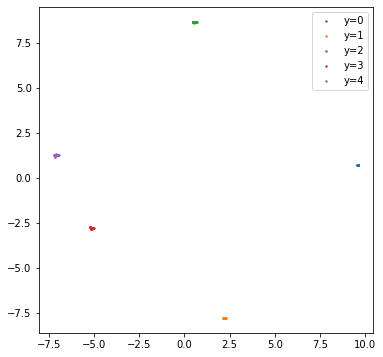

In [19]:
fig, ax = plt.subplots(figsize=(6,6))
for i in np.unique(y):
    ax.scatter(Xenc_pca[y==i,0], Xenc_pca[y==i,1], s=2, label='y={}'.format(i))
    
ax.legend()

The 5 original clusters are well preserved. The encoder does its job !